In [4]:
import random
import numpy as np

#param = [0="weak", 1="strong"]

class User():
    def __init__(self, data_ratio=0.2, param_ratio=0.5):
        data = [0,1]
        param = [0,1]
        
        temp_data = random.choices(data, weights=[1-data_ratio, data_ratio])[0]
        self.param = random.choices(param, weights=[1-param_ratio, param_ratio])[0]
        self.data = Data(temp_data)
        
        self.mec = Mechanism(self.param)
        
    def send(self):
        temp_data = self.mec.perturb(self.data.data)
        return Data(mec=self.mec, data=temp_data, is_perturbed=True, orig_data=self.data.data)

class Mechanism():
    def __init__(self, param=0):
        self.data = [0,1]
        
        def probability(param):
            if param == 0:
                return np.array([[0.8,0.2],[0.2,0.8]])
            else:
                return np.array([[0.6,0.4],[0.4,0.6]])
            
        self.distribution = probability(param)
        self.param=param
    
    def make_mec(self, eps):
        prob = np.exp(eps)/(np.exp(eps) + 1)
        self.distribution = np.array([[prob, 1-prob],[1-prob,prob]])
        return self.distribution
    
    def perturb(self, data):
        distribution = self.distribution[data]
        return random.choices(self.data, distribution)[0]
    
    def cp_LDP_epsilon(self):
        assert self.distribution is not None
        epsilon = np.abs(np.log(self.distribution[0][0] / self.distribution[1][0]))
        return epsilon
    
def cp_PBP_epsilon(mec1, mec2, prior):
    assert np.sum(prior) == 1
    epsilon1 = mec1.cp_LDP_epsilon()
    epsilon2 = mec2.cp_LDP_epsilon()
    
    prior = np.array(prior)
    dist1 = prior[0] * mec1.distribution
    dist2 = prior[1] * mec2.distribution
    
    dif1 = np.abs(np.log(dist1[0][0] / dist2[0][0]))
    dif2 = np.abs(np.log(dist1[0][1] / dist2[0][1]))
    
    epsilon_prime = np.min([epsilon1, epsilon2]) + np.max([dif1, dif2])
    if epsilon_prime < np.max([epsilon1, epsilon2]):
        return epsilon_prime
    else:
        return np.max([epsilon1, epsilon2])

"""
def cp_PBP_epsilon(mec1, mec2, prior):
    assert np.sum(prior) == 1
    
    prior = np.array(prior)
    dist1 = prior[0] * mec1.distribution
    dist2 = prior[1] * mec2.distribution
    
    dif1 = np.log(dist1[0][0] / dist2[1][0])
    dif2 = np.log(dist1[0][1] / dist2[1][1])
    
    dif1_ = np.log(dist1[0][0] / dist1[1][0])
    dif2_ = np.log(dist1[0][1] / dist1[1][1])
    
    epsilon1 = np.max([dif1, dif2])
    epsilon2 = np.max([dif1_, dif2_])
    
    epsilon = np.min([epsilon1, epsilon2])
    
    return epsilon
"""
class Data():
    def __init__(self, data=0 ,is_perturbed=False, orig_data=None, mec=None):
        self.data = data
        
        if is_perturbed:
            self.orig_data = orig_data
            self.mec = mec
            
def cp_fair_eps(param_ratio):
    mec1 = Mechanism(param=0)
    mec2 = Mechanism(param=1)
    eps = cp_PBP_epsilon(mec1, mec2, [param_ratio,1-param_ratio])
    return eps

In [5]:
mec1 = Mechanism(0)
mec2 = Mechanism(1)

<ipython-input-4-47e386439dae>:57: RuntimeWarning: divide by zero encountered in log
  dif1 = np.abs(np.log(dist1[0][0] / dist2[0][0]))
<ipython-input-4-47e386439dae>:58: RuntimeWarning: divide by zero encountered in log
  dif2 = np.abs(np.log(dist1[0][1] / dist2[0][1]))
<ipython-input-4-47e386439dae>:57: RuntimeWarning: divide by zero encountered in double_scalars
  dif1 = np.abs(np.log(dist1[0][0] / dist2[0][0]))
<ipython-input-4-47e386439dae>:58: RuntimeWarning: divide by zero encountered in double_scalars
  dif2 = np.abs(np.log(dist1[0][1] / dist2[0][1]))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque

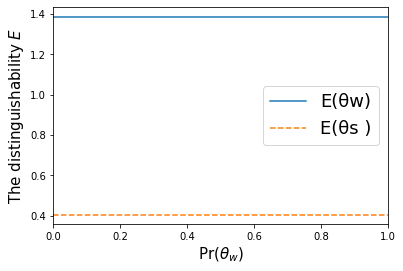

In [16]:
prob = np.linspace(0,1, 50)
eps_range = range(22,33)
eps = []
eps_ = []
for pro in prob:
    mec1 = Mechanism(0)
    mec2 = Mechanism(1)
    theta_w_epsilon = cp_PBP_epsilon(mec1, mec2, [pro, 1-pro])
    theta_s_epsilon = cp_PBP_epsilon(mec2, mec1, [1-pro, pro])
    #eps.append(theta_w_epsilon if theta_w_epsilon >= 0 else 0)
    #eps_.append(theta_s_epsilon if theta_s_epsilon >= 0 else 0)
    #eps.append(cp_fair_eps(pro))
    eps_.append(np.log(1.5))
    eps.append(np.log(4))
    
import matplotlib.pyplot as plt
plt.plot(prob, eps, label="E(θw)")
plt.plot(prob, eps_, label="E(θs )", linestyle="dashed")
plt.xlabel("$\Pr(\\theta_w)$",fontsize=15)
plt.ylabel("The distinguishability $E$",fontsize=15)
plt.legend(fontsize=18)
plt.xlim(0,1)
plt.savefig("results/PBP_parameter.eps",bbox_inches="tight", pad_inches=0.0)

In [17]:
eps_range = range(22,33)
mec = Mechanism()
mec.make_mec(eps[22])

array([[0.8, 0.2],
       [0.2, 0.8]])

In [4]:
import numpy as np

#data_ratio = 0.1
#param_ratio = 0.5

#p_bb = (1-param_ratio) * Mechanism(0).distribution[0][0] + param_ratio * Mechanism(1).distribution[0][0]
def est_pi(obs, p_bb):
    return (p_bb - 1)/(2 * p_bb - 1) + obs/(2 * p_bb - 1)
def var_pi(obs, univ, p_bb):
    pi = est_pi(obs, p_bb)
    return pi*(1-pi)/(univ-1) + (1/(16*((p_bb - 0.5) ** 2)) - (1/4))/(univ-1)
def analyze(collected_data):
    
    univ = len(collected_data)
    
    data_from_param0 = [data for data in collected_data if data.mec.param == 0]
    data_from_param1 = [data for data in collected_data if data.mec.param == 1]
    
    param_ratio = len(data_from_param1)/(len(data_from_param0) + len(data_from_param1))
    
    obs = np.sum([data.data for data in collected_data])/univ
    
    if param_ratio == 0:
        p_bb = data_from_param0[0].mec.distribution[0][0]
    elif param_ratio == 1:
        p_bb = data_from_param1[0].mec.distribution[0][0]
    else:
        param0_00_prob = data_from_param0[0].mec.distribution[0][0]
        param1_00_prob = data_from_param1[0].mec.distribution[0][0]
        p_bb = (1-param_ratio) * param0_00_prob + param_ratio * param1_00_prob
    
    #print("est", est_pi(obs, p_bb))
    #print("std", np.sqrt(var_pi(obs, univ, p_bb)))
    
    return est_pi(obs, p_bb)
    
def collect(data_ratio, param_ratio, num_univ=1000, fair=False):
    collected_data = []
    for _ in range(num_univ):
        user = User(data_ratio=data_ratio, param_ratio=param_ratio)
        if fair:
            if user.mec.param == 0:
                eps = cp_fair_eps(param_ratio)
                user.mec.make_mec(eps)
        sent = user.send()
        collected_data.append(sent)
    return collected_data

In [5]:
def k_0_(data, mec0, mec1, secret=False, param_ratio=None):
    if not secret:
        return 2 * data.mec.distribution[1][data.data] - 1
    else:
        return 2 * (param_ratio * mec1.distribution[1][data.data] + (1-param_ratio) * mec0.distribution[1][data.data]) - 1                
def k_1_(data, mec0, mec1, secret=False, param_ratio=None):
    if not secret:
        return data.mec.distribution[1][data.data] - 1
    else:
        return param_ratio * mec1.distribution[1][data.data] + (1-param_ratio) * mec0.distribution[1][data.data] - 1

def likelyhood(collected_data):
    def likelyhood(ratio):
        result = 0
        for data in collected_data:
            result += np.log(ratio * k_0(data) - k_1(data))
        return result
    return likelyhood

In [6]:
def cp_coef(data):
    other_data = make_other_data(data)
    
    term3 = k_0(data)
    for data_ in other_data:
        term3 *= k_0(data_)
    
    term2 = 0
    for data_ in other_data:
        other_data_ = make_other_data(data_)
        term2 -= k_1(data_)*np.prod([k_0(data__) for data__ in other_data_])
        
    term1 = 0
    for data_ in other_data:
        ohter_data_ = make_other_data(data_)
        term1 += k_0(data) * k_0(data_)*np.prod([k_1(data__) for data__ in other_data_]) / k_1(data)
    #term1 *= k_0(data) / k_1(data)
    
    term0 = -k_0(data)
    for data_ in other_data:
        term0 *= k_1(data_)
    
    return np.array([term3, term2, term1, term0])

In [7]:
def make_other_data(in_data, mec0, mec1):
    param = in_data.mec.param
    data = in_data.data
    
    mec = [mec0, mec1]
    inv_param = int(not param)
    inv_data = int(not data)
    
    data0 = Data(mec=mec[inv_param], data=data, is_perturbed=True)
    data1 = Data(mec=mec[inv_param], data=inv_data, is_perturbed=True)
    data2 = Data(mec=in_data.mec, data=inv_data, is_perturbed=True)
    
    return [data0, data1, data2]

In [10]:
from sympy import solve
from sympy import re
from sympy import Symbol
def max_likelyhood(collected_data, secret=False):
    data_from_param0_and_z0 = [data for data in collected_data if data.mec.param == 0 and data.data == 0]
    data_from_param1_and_z0 = [data for data in collected_data if data.mec.param == 1 and data.data == 0]
    data_from_param0_and_z1 = [data for data in collected_data if data.mec.param == 0 and data.data == 1]
    data_from_param1_and_z1 = [data for data in collected_data if data.mec.param == 1 and data.data == 1]
    
    if len(data_from_param0_and_z0) == 0:
        mec0 = data_from_param0_and_z1[0].mec
    else:
        mec0 = data_from_param0_and_z0[0].mec
    if len(data_from_param1_and_z0) == 0:
        mec1 = data_from_param1_and_z1[0].mec
    else:
        mec1 = data_from_param1_and_z0[0].mec

    z_0w = Data(mec=mec0, data=0, is_perturbed=True)
    z_1w = Data(mec=mec0, data=1, is_perturbed=True)
    z_0s = Data(mec=mec1, data=0, is_perturbed=True)
    z_1s = Data(mec=mec1, data=1, is_perturbed=True)
    
    data_from_param0 = [data for data in collected_data if data.mec.param == 0]
    data_from_param1 = [data for data in collected_data if data.mec.param == 1]
    param_ratio = len(data_from_param1)/(len(data_from_param0) + len(data_from_param1))
    
    #coef = len(data_from_param0_and_z0) * cp_coef(z_0w) + len(data_from_param1_and_z0) * cp_coef(z_0s)\
    #        + len(data_from_param0_and_z1) * cp_coef(z_1w) + len(data_from_param1_and_z1) * cp_coef(z_1s)
    
    x=Symbol('x')
    
    def k_0(data, secret=False, param_ratio=None):
        return k_0_(data, mec0, mec1, secret, param_ratio)
    def k_1(data, secret=False, param_ratio=None):
        return k_1_(data, mec0, mec1, secret, param_ratio)
        
    
    def temp(data, x):
        other_data = make_other_data(data, data_from_param0_and_z0[0].mec, data_from_param1_and_z0[0].mec)
        res = k_0(data)
        for data_ in other_data:
            res *= (x * k_0(data_) - k_1(data_))
        return res
        
    if not secret:

        sol = solve(len(data_from_param0_and_z0) * temp(z_0w, x) + len(data_from_param1_and_z0) * (temp(z_0s, x))\
                   + len(data_from_param0_and_z1) * temp(z_1w, x) + len(data_from_param1_and_z1) * temp(z_1s, x))
        #sol=solve(coef[0] * (x **3) + coef[1] * (x **2) + coef[2] * x + coef[3], x)
        return sol[1]
    else:
        return ((len(data_from_param0_and_z0) + len(data_from_param1_and_z0)) * k_0(z_0w, secret=True, param_ratio=param_ratio)*k_1(z_1w, secret=True, param_ratio=param_ratio)\
        + (len(data_from_param0_and_z1) + len(data_from_param1_and_z1)) * k_0(z_1w, secret=True, param_ratio=param_ratio)*k_1(z_0w, secret=True, param_ratio=param_ratio))\
        / (len(collected_data) * k_0(z_0w, secret=True, param_ratio=param_ratio) * k_0(z_1w, secret=True, param_ratio=param_ratio))
    

In [11]:
def cp_ref(collected_data):
    data_from_0 = [data for data in collected_data if data.orig_data == 0]
    data_from_1 = [data for data in collected_data if data.orig_data == 1]
    return len(data_from_1) / (len(data_from_0) + len(data_from_1))

def accumurate(data_ratio, param_ratio, n_iter=1000, secret=False, is_likelyhood=True, num_univ=1000):
    solved = []
    ref = []
    for _ in range(n_iter):
        collected_data = collect(data_ratio=data_ratio, param_ratio=param_ratio, num_univ=num_univ, fair=not secret)
        if is_likelyhood:
            solved.append(np.float(re(max_likelyhood(collected_data, secret=secret))))
        else:
            if secret:
                solved.append(analyze(collected_data))
            else:
                data_from_param0 = [data for data in collected_data if data.mec.param == 0]
                data_from_param1 = [data for data in collected_data if data.mec.param == 1]
                a = analyze(collected_data)
                b = analyze(data_from_param0)
                c = analyze(data_from_param1)
                solved.append((a,b,c))
        ref.append(cp_ref(collected_data))
        
    if isinstance(solved[0], tuple):
        temps = []
        for i in range(len(solved[0])):
            temps.append(analyze_error([temp[i] for temp in solved], ref, verbose=False)[0])
        argmax = np.argmin(temps)
        solved = [temp[argmax] for temp in solved]
        print(f"choose index {argmax}")
        
    return solved, ref

def accumurate_prior_exp(param_ratio, n_iter=1000, secret=False, is_likelyhood=True, num_univ=100):
    solved = []
    ref = []
    data_ratio = 0.5
    for _ in range(n_iter):
        collected_data = collect(data_ratio=data_ratio, param_ratio=param_ratio, num_univ=num_univ, fair=not secret)
        if is_likelyhood:
            solved.append(np.float(re(max_likelyhood(collected_data, secret=secret))))
        else:
            if secret:
                solved.append(analyze(collected_data))
            else:
                data_from_param0 = [data for data in collected_data if data.mec.param == 0]
                data_from_param1 = [data for data in collected_data if data.mec.param == 1]
                a = analyze(collected_data)
                b = analyze(data_from_param0)
                c = analyze(data_from_param1)
                solved.append((a,b,c))
        ref.append(cp_ref(collected_data))
        
    if isinstance(solved[0], tuple):
        temps = []
        for i in range(len(solved[0])):
            temps.append(analyze_error([temp[i] for temp in solved], ref, verbose=False)[0])
        argmax = np.argmin(temps)
        solved = [temp[argmax] for temp in solved]
        print(f"choose index {argmax}")
        
    return solved, ref

def analyze_error(solved, ref, verbose=True):
    if verbose:
        print(f"estimation: {np.mean([temp for temp in solved])}")
    errors = []
    for solved_, ref_ in zip(solved, ref):
        errors.append(np.sqrt((solved_ - ref_) **2))
    return np.average(errors), np.std(errors)

#### 4通り
- 尤度推定
    - 秘匿パラメータ=True
    - 秘匿パラメータ=False
- 近似
    - 秘匿パラメータ=True
    
比較は秘匿パラメータの最高 vs 公開パラメータの最高

とりあえず最初は三種類で比較すれば良い

色々なデータの分布で試す

In [12]:
def results(data_ratios, secret, n_univ, n_iter):
    results = {data_ratio:0 for data_ratio in data_ratios}
    for data_ratio in data_ratios:
        print(f"data_ratio:{data_ratio}")
        if secret:
            print("secret")
            likely = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=True, is_likelyhood=True, num_univ=n_univ))
            appro = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=True, is_likelyhood=False, num_univ=n_univ))
        else:
            print("public")
            likely = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=False, is_likelyhood=True, num_univ=n_univ))
            appro = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=False, is_likelyhood=False, num_univ=n_univ))
        results[data_ratio] = [likely, appro]
    return results

def results_prior_exp(param_ratios, secret, n_univ, n_iter):
    results = {param_ratio:0 for param_ratio in param_ratios}
    for param_ratio in param_ratios:
        print(f"param_ratio:{param_ratio}")
        if secret:
            print("secret")
            likely = analyze_error(*accumurate_prior_exp(param_ratio=param_ratio, n_iter=n_iter, secret=True, is_likelyhood=True, num_univ=n_univ))
            appro = analyze_error(*accumurate_prior_exp(param_ratio=param_ratio, n_iter=n_iter, secret=True, is_likelyhood=False, num_univ=n_univ))
        else:
            print("public")
            likely = analyze_error(*accumurate_prior_exp(param_ratio=param_ratio, n_iter=n_iter, secret=False, is_likelyhood=True, num_univ=n_univ))
            appro = analyze_error(*accumurate_prior_exp
                                  (param_ratio=param_ratio, n_iter=n_iter, secret=False, is_likelyhood=False, num_univ=n_univ))
        results[param_ratio] = [likely, appro]
    return results

In [ ]:
#import pickle
#prob = np.linspace(0,1, 10)
#n_univ = 100
#n_iter = 10000
#results_secret = results(data_ratios=prob, secret=True, n_univ=n_univ, n_iter=n_iter)
#results_public = results(data_ratios=prob, secret=False, n_univ=n_univ, n_iter=n_iter)

#with open(f"data/univ_{n_univ}_para_{0.5}_n_iter_{n_iter}_.pkl", "wb") as f:
#    pickle.dump([results_public, results_secret], f)
    
import pickle
#prob = np.linspace(0,1, 11)
#n_univ = 1000
#n_iter = 10000
#results_secret_ = results(data_ratios=prob, secret=True, n_univ=n_univ, n_iter=n_iter)
#results_public = results(data_ratios=prob, secret=False, n_univ=n_univ, n_iter=n_iter)

# open(f"data/univ_{n_univ}_para_{0.5}_n_iter_{n_iter}_.pkl", "wb") as f:
#    pickle.dump([results_public, results_secret], f)
    

import pickle
prob = np.linspace(0,1, 11)
n_univ = 10000
n_iter = 10000
results_secret_ = results(data_ratios=prob, secret=True, n_univ=n_univ, n_iter=n_iter)
#results_public = results(data_ratios=prob, secret=False, n_univ=n_univ, n_iter=n_iter)

#with open(f"data/univ_{n_univ}_para_{0.5}_n_iter_{n_iter}_.pkl", "wb") as f:
#    pickle.dump([results_public, results_secret], f)

data_ratio:0.0
secret
estimation: 2.399265453769529e-05
estimation: -5.1270405468015244e-05
data_ratio:0.1
secret
estimation: 0.10006406826526452
estimation: 0.09986592295400494
data_ratio:0.2
secret
estimation: 0.19994448571755696
estimation: 0.20019505256645842
data_ratio:0.30000000000000004
secret
estimation: 0.29992326083770443
estimation: 0.30001925379120487
data_ratio:0.4
secret
estimation: 0.3998654359206104
estimation: 0.399995761289543
data_ratio:0.5
secret


In [124]:
#with open(f"data/univ_{n_univ}_para_{0.5}_n_iter_{n_iter}_temp_.pkl", "wb") as f:
#    pickle.dump([results_public, results_secret_], f)

In [125]:
prob = np.linspace(0,1, 11)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


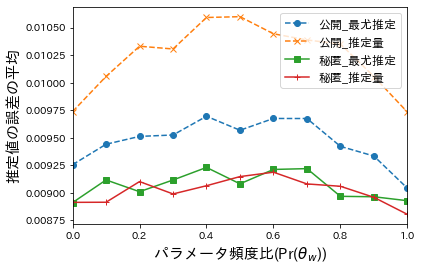

In [127]:
import japanize_matplotlib
import matplotlib.pyplot as plt
data_ratios = list(results_public.keys())
plt.plot(data_ratios, [result[0][0] for _, result in results_public.items()], linestyle="dashed", marker="o", label="公開_最尤推定")
plt.plot(data_ratios, [result[1][0] for _, result in results_public.items()], linestyle="dashed", marker="x", label="公開_推定量")
plt.plot(data_ratios, [result[0][0] for _, result in results_secret_.items()], marker="s", label="秘匿_最尤推定")
plt.plot(data_ratios, [result[1][0] for _, result in results_secret_.items()], marker="+", label="秘匿_推定量")
plt.legend(fontsize=12)
plt.xlabel("パラメータ頻度比(Pr($θ_w$))", fontsize=15)
plt.ylabel("推定値の誤差の平均", fontsize=15)
plt.xlim(0,1)

plt.savefig(f"results/univ_{n_univ}_para_{0.5}_n_iter_{n_iter}_temp.eps",bbox_inches="tight", pad_inches=0.0)

In [ ]:
results_secret

In [9]:
n_univ = 10000
n_iter = 10000
data_ratios = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
results_secret = results(data_ratios, secret=True, n_univ=n_univ, n_iter=n_iter)
#results_public = results(data_ratios, secret=False, n_univ=n_univ, n_iter=n_iter)

data_ratio:0
secret


KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
plt.plot(data_ratios, [result[0][0] for _, result in results_public.items()], label="public_likelyhood")
plt.plot(data_ratios, [result[1][0] for _, result in results_public.items()], label="public_estimator")
plt.plot(data_ratios, [result[0][0] for _, result in results_secret.items()], label="secret_likelyhood")
plt.plot(data_ratios, [result[1][0] for _, result in results_secret.items()], label="secret_estimator")
plt.legend()
#plt.savefig(f"results/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.eps")

NameError: name 'data_ratios' is not defined

Text(0, 0.5, '推定値の誤差の平均')

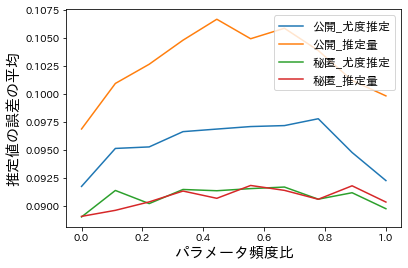

In [68]:
import matplotlib.pyplot as plt
data_ratios = list(results_public.keys())
n_univ = 100
plt.plot(data_ratios, [result[0][0] for _, result in results_public.items()], label="公開_尤度推定")
plt.plot(data_ratios, [result[1][0] for _, result in results_public.items()], label="公開_推定量")
plt.plot(data_ratios, [result[0][0] for _, result in results_secret.items()], label="秘匿_尤度推定")
plt.plot(data_ratios, [result[1][0] for _, result in results_secret.items()], label="秘匿_推定量")
plt.legend(fontsize=12)
plt.xlabel("パラメータ頻度比", fontsize=15)
plt.ylabel("推定値の誤差の平均", fontsize=15)


#plt.savefig(f"results/univ_{n_univ}_data_{0.5}_n_iter_{10000}.eps",bbox_inches="tight", pad_inches=0.0)

In [123]:
import pickle
#with open(f"data/univ_{100}_data_{0.5}_n_iter_{10000}_para_.pkl", "wb") as f:
#    pickle.dump([results_public, results_secret], f)
with open(f"data/univ_{n_univ}_param_{0.5}_n_iter_{n_iter}.pkl", "rb") as f:
    results_public, results_secret = pickle.load(f)

In [97]:
#n_univ = 10000
param_ratio = 0.5
#n_iter = 10000
with open(f"data/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.pkl", "rb") as f:
    results_public, results_secret = pickle.load(f)